# E.D.A.: CORRELATION BETWEEN  UNEMPLOYMENT & SUICIDE RATES IN 43 COUNTRIES FROM 2000 TO 2016  
By Daniel Del Valle González  2020-2021

## STEP 1 - DATA CLEANING & NORMALISING
## STEP 2 - DATA ANALISYS & TENDENCIES. TOP & BOTTOM COUNTRIES IN SUICIDE & UNEMPLOYMENT RATES
## STEP 3 - GRAPHIC VISUALISATION OF EACH DATAFRAME TENDENCIES
## STEP 4 - GRAPHIC VISUALISATION OF CORRELATIONS

## STEP 1 - DATA CLEANING & NORMALISING

### We got 2 csv from:   
1 - https://www.kaggle.com/szamil/who-suicide-statistics csv for suicides from 2000.  
2 - https://stats.oecd.org/Index.aspx?QueryId=64198# csv for unemployment rates. I selected and added some countries that by defect were not included.  

We create 2 DataFrames from them:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import psutil
from utils.folders_tb import *
from utils.mining_data_tb import *
from utils.visualization_tb import *

## Both had to be cleaned and "synchronised" in many ways:

In [3]:
suicide = pd.read_csv("C:\\DATA_SCIENCE\\PROYECTO\\documentation\\who_suicide_statistics.csv")
unemployment = pd.read_csv("C:\\DATA_SCIENCE\\PROYECTO\\documentation\\unemployment_all_ratio.csv")

In [4]:
suic, unemp = intersector(df1=suicide, df2=unemployment, col1="country", col2="Country")      #creating dataframes with data about only their shared countries

In [5]:
print(suic.info(), unemp.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17808 entries, 2160 to 41915
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      17808 non-null  object 
 1   year         17808 non-null  int64  
 2   sex          17808 non-null  object 
 3   age          17808 non-null  object 
 4   suicides_no  16716 non-null  float64
 5   population   17808 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 973.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 176782 entries, 0 to 199886
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   COUNTRY                176782 non-null  object 
 1   Country                176782 non-null  object 
 2   SEX                    176782 non-null  object 
 3   Sex                    176782 non-null  object 
 4   AGE                    176782 non-null  int64  
 5   Ag

### Unemployment CSV included "employment rate" and other values (columns). We only select those regarding to "unemployment rate"

In [6]:
unemp = only_desired(df=unemp, col1="Series", desired="Unemployment rate")  #selecting onlye "unemployment" stadistic values

### Unemployment DataFrame had some groups of countries that did not appear on the Suicides Rates DataFrame, so are discarded.

In [7]:
unemp = str_discarder(unemp, "Country", "OECD")                              #discarding groups of countries(no info in the other dataframe)
unemp = str_discarder(unemp, "Country", "Euro")

### Columns and values from both dataframes are to be renamed with similar names to allow easy contrast

In [8]:
unemp = column_renamer(unemp, ['SEX', 'Value', 'Time'], ['Gender', 'Unemploy_Rate', 'Year'])
suic = column_renamer(suic, ['sex'], ['gender'])

In [9]:
unemp = unemp[['Country', 'Gender', 'Age', 'Year', 'Unemploy_Rate']]      #selection only useful columns in uneployment dataframe

In [10]:
column_lower(suic)                                                        #normalising columns names
column_lower(unemp)                                                                    

In [11]:
value_renamer(unemp, "gender", "MEN", "male")                             #normalising "gender" column formats   
value_renamer(unemp, "gender", "WOMEN", "female")

In [12]:
str_cleaner(suic, "age", "years ")

In [13]:
str_replacer(unemp, "age", " to ", "-")

In [14]:
value_discarder(suic, "age", "5-14")                                          #discarding 2 age ranges that are irrelevant for unemployment rate 
value_discarder(suic, "age", "75+")
value_discarder(unemp, "gender", "MW")                                      #discarding MW values as they are ambiguous, unaccurate summatories

In [15]:
unemp.gender.value_counts()

male      19492
female    19394
Name: gender, dtype: int64

In [16]:
suic.age.value_counts()

55-74    2968
25-34    2968
35-54    2968
15-24    2968
Name: age, dtype: int64

### Dataframes had data in different years ranges, so we had to cut them to fit:

In [17]:
unemp = unemp[unemp['year'] <= 2016]
suic = suic[suic['year'] >= 2000]

### On the "age" columns the ranges where different (fewer and broader in Suicides Df, narrower in Unemployment Df. Synchronisation was not an easy task)

In [18]:
unemp = unemp[(unemp['age'] == '15-24') | (unemp['age'] == '25-34') |(unemp['age'] == '35-44') |(unemp['age'] == '45-54') | (unemp['age'] == '55-64') |(unemp['age'] == '65-69') | (unemp['age'] == '70-74')]


In [19]:
unemp = unemp[(unemp['age'] == '15-24') | (unemp['age'] == '25-34') |(unemp['age'] == '35-44') |(unemp['age'] == '45-54') | (unemp['age'] == '55-64') |(unemp['age'] == '65-69') | (unemp['age'] == '70-74')]                                                                                               #discarding duplicated age ranges(some are include inside others) 

unemp.loc[(unemp["age"] == '35-44') | (unemp["age"] == '45-54'), 'age'] = '35-54'                                  #merging smaller ranges into a bigg one (and common with my other csv)
unemp.loc[(unemp["age"] == '55-64') | (unemp["age"] == '65-69') | (unemp["age"] == '70-74'), 'age'] = "55-74"

## STEP 2 - DATA ANALISYS & TENDENCIES. TOP & BOTTOM COUNTRIES IN SUICIDE & UNEMPLOYMENT RATES

### A common measure of suicide in stadistics is "suicies per 100k people", so we add a column containing those values for each slice of population, given that we have the info.

In [20]:
add_ratio(suic, "suic_100k", "suicides_no", "population", 100000, 2)   #creating a column with desired value; just 2 decimals is enough

### We create some sub-dataframes with info centered in distribution per Country:

In [21]:
suic_countries_mean = gr_meaner(suic, "country", "suic_100k")
unemp_countries_mean = gr_meaner(unemp, "country", "unemploy_rate")

### Then we create some sub-dataframes with info centered in Age: 

In [22]:
suic_ages_mean = gr_meaner(suic, "age", "suic_100k")
unemp_ages_mean = gr_meaner(unemp, "age", "unemploy_rate")

### We also create sub-dataframes for distribution in Gender: 

In [23]:
suic_genders_mean = gr_meaner(suic, "gender", "suicides_no")
unemp_genders_mean = gr_meaner(unemp, "gender", "unemploy_rate")

### Suicide Top and Bottom Countries

In [24]:
most_per_100k , least_per_100k = most_least(suic, 'country', 'suic_100k', 5)

### Unemployment Top and Bottom Countries

In [25]:
most_unemp, least_unemp = most_least(unemp, "country", "unemploy_rate", 5)

### >>> Pivot Tables   (they provide more visual chances. Getting plotted in the future) <<<

In [26]:
suic_pivot = pd.pivot_table(suic, index = ['country', 'year'], values = ['suicides_no', 'suic_100k']).round(2)
suic_pivot_mean_gndr = pd.pivot_table(suic, index = ['country', 'year', 'gender'], values = ['suic_100k']).round(2)

sp_su = suic_pivot.loc["Spain"]
sp_su_mean = suic_pivot_mean_gndr.loc["Spain"]

lt_su = suic_pivot.loc["Lithuania"]
ru_su = suic_pivot.loc["Russian Federation"]
tu_su = suic_pivot.loc["Turkey"]
sa_su = suic_pivot.loc["South Africa"]


In [27]:
sp_su
spain_suc = px.line(sp_su)
spain_suc.update_layout(title='"Unemployment Mean Rate Evolution in Spain, 2000 - 2016"', font=dict(family="Arial", size=17))

In [28]:
unemp_pivot = pd.pivot_table(unemp, index = ['country', 'year'], values = ['unemploy_rate']).round(2)
unemp_pivot_mean_gndr = pd.pivot_table(unemp, index = ['country', 'year', 'gender'], values = ['unemploy_rate']).round(2)

sp_un = unemp_pivot_mean_gndr.loc["Spain"] 
sp_un_mean = unemp_pivot.loc["Spain"]

nw_un = unemp_pivot.loc["Norway"]
sa_un = unemp_pivot.loc["South Africa"]

In [29]:
sp_un

unemploy_rate
year gender               
2000 female          15.31
     male             8.64
2001 female          11.21
     male             6.74
2002 female          11.88
     male             6.83
2003 female          12.13
     male             7.04
2004 female          11.34
     male             6.84
2005 female          10.02
     male             6.17
2006 female           9.15
     male             5.49
2007 female           8.84
     male             5.50
2008 female          10.85
     male             8.31
2009 female          14.87
     male            14.61
2010 female          15.99
     male            16.75
2011 female          17.92
     male            18.05
2012 female          21.23
     male            21.03
2013 female          22.90
     male            22.53
2014 female          22.12
     male            21.33
2015 female          20.03
     male            19.00
2016 female          19.16
     male            17.09

In [30]:
sp_un_mean
spainfig = px.area(sp_un_mean)
spainfig.update_layout(title='"Unemployment Mean Rate Evolution in Spain, 2000 - 2016"', font=dict(family="Arial", size=17))
spainfig.write_html("..\\reports\\html\\unemp_Spain.html")
spainfig.write_image("..\\reports\\png\\unemp_Spain.png", width=1280, height=960)
spainfig

## Suicide DataFrame Graphs

In [31]:
sfig = go.Figure()
sfig.add_trace(go.Bar(x=suic_countries_mean.suic_100k, y=suic_countries_mean.index, orientation="h", name="Suicide Rate/100k people"))
sfig.update_layout(legend=dict(x=0,y=1), xaxis=dict(tickmode='linear', tick0=0, dtick=2.5), width=1500, height=800, yaxis=dict(tickmode='linear'))
sfig.update_layout(title='Suicide Mean Rate Per Country per 100k/people (2000 - 2016)', font=dict(family="Arial", size=17))
sfig.write_html("..\\reports\\html\\suicHBars.html")
sfig.write_image("..\\reports\\png\\suicHBars.png", width=1280, height=960)

In [32]:
fig_ages_suic = px.pie(suic_ages_mean, values='suic_100k', names=suic_ages_mean.index, title='Suicide Mean Rate per Age Range, per 100k/people, 2000-2016',color_discrete_sequence=px.colors.sequential.RdBu)
fig_ages_suic.write_html("..\\reports\\html\\suic_ages_pie.html")
fig_ages_suic.write_image("..\\reports\\png\\suic_ages_pie.png", width=1280, height=960)

In [33]:
fig_s = px.pie(suic, values='suicides_no', names='gender', title='Suicide Ratio per Gender, 2000-2016')    #using total number of suicides for a more descriptive info about each age range
fig_s.write_html("..\\reports\\html\\suicPieGender.html")
fig_s.write_image("..\\reports\\png\\suicPieGender.png", width=1280, height=960)

## Unemployment DataFrame Graphs


In [34]:
ucm = go.Figure()
ucm.add_trace(go.Bar(x=unemp_countries_mean.index, y=unemp_countries_mean.unemploy_rate,  name="Unemployment Mean Rate 200-2016"))
ucm.update_layout(width=1400, height=750, title='Unemployment Mean Rate Per Country % (2000 - 2016)')
ucm.update_layout(xaxis=dict(tickmode='linear', tick0=0, dtick=0.75, tickangle = 310), font=dict(family="Arial", size=20))
sfig.write_html("..\\reports\\html\\ucm.html")
sfig.write_image("..\\reports\\png\\ucm.png", width=1280, height=960)

In [35]:
fig_ages_unemp = px.pie(unemp_ages_mean, values='unemploy_rate', names=unemp_ages_mean.index, title='Unemployment Mean Rate per Age Range, 2000-2016', color_discrete_sequence=px.colors.sequential.RdBu_r)
fig_ages_unemp.write_html("..\\reports\\html\\unemp_ages_pie.html")
fig_ages_unemp.write_image("..\\reports\\png\\unemp_ages_pie.png", width=1280, height=960)

In [36]:
fig_u = px.pie(unemp, values='unemploy_rate', names='gender', title='Unemployment Ratio per Gender, 2000-2016')
fig_u.write_html("..\\reports\\html\\unempPieGender.html")
fig_u.write_image("..\\reports\\png\\unempPieGender.png", width=1280, height=960)

## STEP 4 - GRAPHIC VISUALISATION OF CORRELATIONS

In [37]:
suic_ages_mean2 = suic.groupby('age').mean().round(2)          #having population in mind, just in case it has some correlation
suic_ages_mean2.drop(columns=['year', 'population'], inplace=True)

In [38]:
suic_ages_mean2

,suicides_no,suic_100k
age,,
15-24,201.34,9.28
25-34,286.99,12.70
35-54,680.60,17.42
55-74,471.28,18.45


In [39]:
mrg_ages = pd.merge(suic_ages_mean2, unemp_ages_mean, on='age', how='inner')
mrg_ages

,suicides_no,suic_100k,unemploy_rate
age,,,
15-24,201.34,9.28,18.68
25-34,286.99,12.70,9.07
35-54,680.60,17.42,6.37
55-74,471.28,18.45,3.06


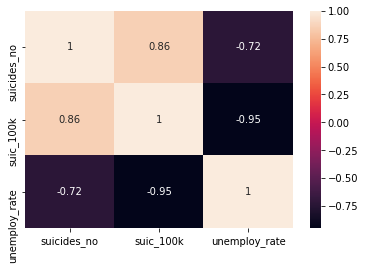

In [40]:
mrg_ages_matrix = sns.heatmap(mrg_ages.corr(), xticklabels=mrg_ages.columns, yticklabels=mrg_ages.columns, annot=True)
mrg_ages_matrix
a4_dims = (11.7, 8.27)
mrg_ages_matrix.figure.savefig("..\\reports\\png\\correlation_matrix.png", dpi=1200, figsize=a4_dims ,bbox_inches='tight')

In [41]:
mrg_countries = pd.merge(unemp_countries_mean, suic_countries_mean, on='country', how='inner')
mrg_countries = mrg_countries.sort_values('unemploy_rate')

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=mrg_countries.index, y=mrg_countries.unemploy_rate,mode='markers+lines', name="Unemployment Rate %"))
fig.add_trace(go.Scatter(x=mrg_countries.index, y=mrg_countries.suic_100k, mode='markers+lines', name="Suicide Rate per 100k/population"))
fig.update_layout(legend=dict(x=0,y=1),xaxis=dict(tickmode='linear', tick0=0, tickangle=320), width=1500, height=750, title="Unemployment and Suicide Mean Rates Contrasted, 200-2016")
fig.show()
fig.write_html("..\\reports\\html\\contrast_lines_countries.html")
fig.write_image("..\\reports\\png\\contrast_lines_countries.png", width=1280, height=960)

In [43]:
suic_genders_mean2 = suic.groupby('gender').mean().round(2)          #having population in mind, just in case it has some correlation
suic_genders_mean2.drop(columns=['year', 'population'], inplace=True)

In [44]:
gendermerge = pd.merge(suic_genders_mean2, unemp_genders_mean, on='gender')
gendermerge

,suicides_no,suic_100k,unemploy_rate
gender,,,
female,170.91,5.90,7.44
male,649.19,23.03,7.02


## STEP 5 - GRAPHIC VISUALISATION OF TIME EFFORT DISTRIBUTION

In [45]:
labels = ['Data Search','Data Cleaning','Data Analysis','Data Plotting', 'Format Adapting']
values = [5, 50, 35, 25]

fig5 = go.Figure(data=[go.Pie(labels=labels, values=values, textfont=dict(color='black',size=18))])
fig5.show()
fig5.write_html("..\\reports\\html\\pie.html")
fig5.write_image("..\\reports\\png\\pie.png", width=1280, height=960)